In [30]:
import numpy as np

class PPOMemory:
    
    def __init__(self, batch_size):
        self.states = []
        self.probs = []  # 动作采样的概论
        self.vals = []  # 当前的价值
        self.actions = []
        self.rewards = []
        self.dones = []
        self.batch_size = batch_size
        
    def sample(self):
        batch_step = np.arange(0, len(self.states), self.batch_size)
        indices = np.arange(len(self.states), dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_step]
        return np.array(self.states),np.array(self.actions),np.array(self.probs),\
                np.array(self.vals),np.array(self.rewards),np.array(self.dones),batches
                
    def push(self, state, action, probs, vals, reward, done):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)
        self.dones.append(done)

    def clear(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.dones = []
        self.vals = []

In [31]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical

class Actor(nn.Module):
    def __init__(self,state_dim, action_dim, hidden_dim):
        super(Actor, self).__init__()

        self.actor = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, action_dim),
                nn.Softmax(dim=-1)
        )
    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        return dist

class Critic(nn.Module):
    def __init__(self, state_dim,hidden_dim):
        super(Critic, self).__init__()
        self.critic = nn.Sequential(
                nn.Linear(state_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 1)
        )
    def forward(self, state):
        value = self.critic(state)
        return value

In [32]:
# 关于log_prob的用法

import torch.nn.functional as F

action_logits = torch.rand(5)
action_probs = F.softmax(action_logits, dim=-1)
print(f'action_probs={action_probs}')

dist = Categorical(action_probs)
action = dist.sample()
print(f'action={action}')
print(f'1) log_prob: {dist.log_prob(action)}')
print(f'2) log_prob: {torch.log(action_probs[action])}')

action_probs=tensor([0.1981, 0.2113, 0.2017, 0.2174, 0.1715])
action=4
1) log_prob: -1.7631953954696655
2) log_prob: -1.763195514678955


In [33]:
import os
import numpy as np
import torch 
import torch.optim as optim

In [34]:
class PPO:
    
    def __init__(self, state_dim, action_dim,cfg):
        self.gamma = cfg.gamma
        self.continuous = cfg.continuous  # 是否连续动作
        self.policy_clip = cfg.policy_clip
        self.n_epochs = cfg.n_epochs
        self.gae_lambda = cfg.gae_lambda  # what
        self.device = cfg.device
        self.actor = Actor(state_dim, action_dim, cfg.hidden_dim).to(self.device)
        self.critic = Critic(state_dim,cfg.hidden_dim).to(self.device)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=cfg.actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=cfg.critic_lr)
        self.memory = PPOMemory(cfg.batch_size)
        self.loss = 0
        
    def choose_action(self, state):
        state = torch.tensor([state], dtype=torch.float).to(self.device)
        dist = self.actor(state)   # 输出动作的概率
        value = self.critic(state)
        action = dist.sample()
        probs = torch.squeeze(dist.log_prob(action)).item()
        if self.continuous:
            action = torch.tanh(action)
        else:
            action = torch.squeeze(action).item()
        value = torch.squeeze(value).item()
        
        return action, probs, value
    
    def update(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,reward_arr, dones_arr, batches = self.memory.sample()
            values = vals_arr[:]
            ### compute advantage ###
            advantage = np.zeros(len(reward_arr), dtype=np.float32)
            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    
                    # reward_arr[k] + self.gamma*values[k+1]*(1-int(dones_arr[k]))为Q函数
                    discount *= self.gamma*self.gae_lambda  # what
                advantage[t] = a_t
            advantage = torch.tensor(advantage).to(self.device)
            
            ### SGD ###
            values = torch.tensor(values).to(self.device)
            for batch in batches:
                states = torch.tensor(state_arr[batch], dtype=torch.float).to(self.device)
                old_probs = torch.tensor(old_prob_arr[batch]).to(self.device)
                actions = torch.tensor(action_arr[batch]).to(self.device)
                dist = self.actor(states)
                critic_value = self.critic(states)
                critic_value = torch.squeeze(critic_value)
                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = torch.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -torch.min(weighted_probs, weighted_clipped_probs).mean()
                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()
                total_loss = actor_loss + 0.5*critic_loss   # what还有这个操作啊！
                self.loss  = total_loss
                self.actor_optimizer.zero_grad()
                self.critic_optimizer.zero_grad()
                total_loss.backward()
                self.actor_optimizer.step()
                self.critic_optimizer.step()
        self.memory.clear()  

In [47]:
def train(cfg,env,agent):
    print('开始训练！')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    steps = 0
    for i_ep in range(cfg.train_eps):
        state = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action, prob, val = agent.choose_action(state)
            state_, reward, done, _ = env.step(action)
            steps += 1
            ep_reward += reward
            agent.memory.push(state, action, prob, val, reward, done)
            if steps % cfg.update_fre == 0:
                agent.update()
            state = state_
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
        if (i_ep+1)%10 == 0: 
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print('完成训练！')
    return rewards,ma_rewards

In [48]:
def eval(cfg,env,agent):
    print('开始测试!')
    print(f'环境：{cfg.env_name}, 算法：{cfg.algo_name}, 设备：{cfg.device}')
    rewards = [] # 记录所有回合的奖励
    ma_rewards = []  # 记录所有回合的滑动平均奖励
    for i_ep in range(cfg.test_eps):
        state = env.reset()
        done = False
        ep_reward = 0
        while not done:
            action, prob, val = agent.choose_action(state)
            state_, reward, done, _ = env.step(action)
            ep_reward += reward
            state = state_
        rewards.append(ep_reward)
        if ma_rewards:
            ma_rewards.append(
                0.9*ma_rewards[-1]+0.1*ep_reward)
        else:
            ma_rewards.append(ep_reward)
        print('回合：{}/{}, 奖励：{}'.format(i_ep+1, cfg.test_eps, ep_reward))
    print('完成训练！')
    return rewards,ma_rewards

In [49]:
import sys,os
curr_path = os.path.dirname(os.path.realpath('__file__')) # 当前文件所在绝对路径
parent_path = os.path.dirname(curr_path) # 父路径
sys.path.append(parent_path) # 添加路径到系统路径

import gym
import torch
import datetime
from common.utils import save_results,make_dir, plot_rewards

curr_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")  # 获取当前时间

In [50]:
class PPOConfig:
    def __init__(self) -> None:
        self.algo_name = "PPO"  # 算法名称
        self.env_name = 'CartPole-v1' # 环境名称
        self.continuous = False # 环境是否为连续动作
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检测GPU
        self.train_eps = 200 # 训练的回合数
        self.test_eps = 20 # 测试的回合数
        self.batch_size = 5
        self.gamma=0.99
        self.n_epochs = 4
        self.actor_lr = 0.0003
        self.critic_lr = 0.0003
        self.gae_lambda=0.95
        self.policy_clip=0.2
        self.hidden_dim = 256
        self.update_fre = 20 # frequency of agent update
        self.save = False
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # 检测GPU

In [51]:
def env_agent_config(cfg,seed=1):
    env = gym.make(cfg.env_name)  
    env.seed(seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    agent = PPO(state_dim,action_dim,cfg)
    return env,agent


In [52]:
# 训练
cfg = PPOConfig()
env, agent = env_agent_config(cfg)
rewards, ma_rewards = train(cfg, env, agent)

开始训练！
环境：CartPole-v1, 算法：PPO, 设备：cuda


C:\Users\Administrator\AppData\Local\Temp\ipykernel_79436\1378480071.py:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:210.)
  state = torch.tensor([state], dtype=torch.float).to(self.device)


回合：10/200，奖励：38.00
回合：20/200，奖励：18.00
回合：30/200，奖励：16.00
回合：40/200，奖励：45.00
回合：50/200，奖励：61.00
回合：60/200，奖励：296.00
回合：70/200，奖励：102.00
回合：80/200，奖励：180.00
回合：90/200，奖励：150.00
回合：100/200，奖励：164.00
回合：110/200，奖励：500.00
回合：120/200，奖励：236.00
回合：130/200，奖励：368.00
回合：140/200，奖励：500.00
回合：150/200，奖励：178.00
回合：160/200，奖励：440.00
回合：170/200，奖励：159.00
回合：180/200，奖励：500.00
回合：190/200，奖励：500.00
回合：200/200，奖励：327.00
完成训练！


D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
D:\ProgramData\Anaconda3\envs\hoho_gym\lib\site-packages\setuptools\_distutils\version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


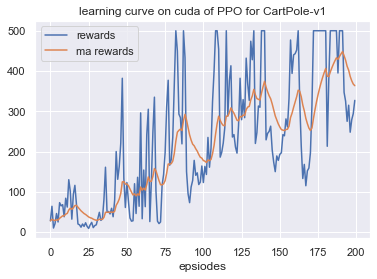

In [54]:
plot_rewards(rewards, ma_rewards, cfg, tag="train")

开始测试!
环境：CartPole-v1, 算法：PPO, 设备：cuda
回合：1/20, 奖励：316.0
回合：2/20, 奖励：342.0
回合：3/20, 奖励：346.0
回合：4/20, 奖励：342.0
回合：5/20, 奖励：303.0
回合：6/20, 奖励：310.0
回合：7/20, 奖励：348.0
回合：8/20, 奖励：330.0
回合：9/20, 奖励：337.0
回合：10/20, 奖励：318.0
回合：11/20, 奖励：319.0
回合：12/20, 奖励：345.0
回合：13/20, 奖励：330.0
回合：14/20, 奖励：306.0
回合：15/20, 奖励：311.0
回合：16/20, 奖励：303.0
回合：17/20, 奖励：336.0
回合：18/20, 奖励：313.0
回合：19/20, 奖励：331.0
回合：20/20, 奖励：342.0
完成训练！


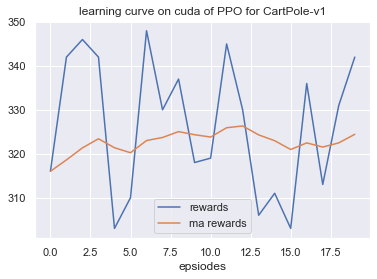

In [55]:
# 测试
rewards,ma_rewards = eval(cfg,env,agent)
plot_rewards(rewards,ma_rewards,cfg,tag="eval")